## Experiment Evaluation

In [1]:
evaluation_file = '../data/output/output.csv'
plot_output_path = '../plots/'

In [2]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import re
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", rc={'text.usetex' : True, 'text.latex.unicode': True, 'text.latex.preamble': [r'\usepackage{amsmath}']})
font_scale=2.2
sns.set_context("notebook", font_scale=font_scale)
plt.rcParams['figure.figsize'] = (10,10)
# Set "True" to output tables in tex-style
print_latex = False

In [3]:
def pretty_plot(title="Plot", f=sns.catplot, plot_size=(12, 5), pretty_order=None, pretty_hue_order=None, **kwargs):
    if 'hue' in kwargs:
        kwargs['hue_order'] = order[kwargs['hue']] if pretty_hue_order is None else pretty_hue_order
    if 'x' in kwargs and f != sns.scatterplot and f != sns.pointplot:
        kwargs['order'] = order[kwargs['x']] if pretty_order is None else pretty_order
    fig, ax = plt.subplots()
    _ = fig.set_size_inches(plot_size)
    g = f(ax=ax, **kwargs)
    if type(g) == sns.axisgrid.FacetGrid:
        plt.close(g.fig)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return fig

In [4]:
def highlight_max(data, color='gray'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [5]:
order = {
    'qs': ['RandomQss', 'RandomOutlierQss', 'DecisionBoundaryQss', 'ExplorativeMarginQss_NP', 'ExplorativeMarginQss'],
    'data_set': ["ALOI", "Annthyroid", "Arrhythmia", "Cardiotocography", "Glass",
             "HeartDisease", "Hepatitis", "Ionosphere", "KDDCup99", "Lymphography",
             "PageBlocks", "Parkinson", "PenDigits", "Pima", "Shuttle", "SpamBase",
             "Stamps", "WBC", "WDBC", "WPBC", "Waveform"],
    'qs_opt_method': ['None', 'ParticleSwarmOptimization', 'BlackBoxOptimization']
}
pretty_names = {
                'AEQ': {'m_average_end_quality': 'MCC', 'c_average_end_quality': 'kappa', 'auc_average_end_quality': 'AUC', 'pauc_average_end_quality': 'PAUC'},
                'AEQ-M': {'m_average_end_quality': 'MCC-AEQ', 'c_average_end_quality': 'kappa-AEQ', 'auc_average_end_quality': 'AUC-AEQ', 'pauc_average_end_quality': 'PAUC-AEQ'},
                'SQ-M': {'m_start_quality': 'MCC-SQ', 'k_start_quality': 'kappa-SQ', 'auc_start_quality': 'AUC-SQ', 'pauc_start_quality': 'PAUC-SQ'},
                'MCC': {'m_start_quality': 'SQ', 'm_end_quality': 'EQ', 'm_average_end_quality': 'AEQ', 'm_ramp_up': 'RU'},
                'qs': {
                    'RandomQss': '$DQSS_{\\text{rand}}$',
                    'RandomOutlierQss': '$DQSS_{\\text{rand-o}}$',
                    'DecisionBoundaryQss': '$IQSS_{\\text{DB}}$',
                    'ExplorativeMarginQss_NP': '$IQSS_{\\text{DES}}$',
                    'ExplorativeMarginQss': '$IQSS^*_{\\text{DES}}$',
                  },
}

In [6]:
def load_csv_file(f):
    df = pd.read_csv(f)
    df.split_strategy = df.split_strategy.apply(str)
    # merge kde_errors
    df.exit_code = df.exit_code.apply(lambda x: 'kde_error' if x in ["KDEException", "PyCall.PyError"] else x)
    df.exit_code = df.exit_code.apply(lambda x: 'missing_label' if x == "MissingLabelTypeException" else x)
    df.exit_code = df.exit_code.apply(lambda x: 'missing_train_data' if x == "InexactError" else x)
    df['qs'] = df[['qs', 'qs_use_penalty']].apply(lambda x: f"{x[0]}_NP" if not x[1] else x[0], axis=1)
    df['qs_opt_method'] = df['qs_opt_method'].fillna("None")
    df_data_gen = pd.DataFrame([[int(s) for s in re.findall(r'\d+', x)] for x in df['file_name'].values], index=df.index, columns=["seed", "x", "num_gaussians", "num_gaussians_train"])[["seed", "num_gaussians", "num_gaussians_train"]]
    df = pd.concat([df, df_data_gen], axis=1)
    df_success = df.query('exit_code == "success"').reset_index(drop=True)
    return df, df_success

In [7]:
df_full, df_full_success = load_csv_file(evaluation_file)

In [8]:
f"Total experiment run time: {str(datetime.timedelta(seconds=np.sum(df_full.total_run_time)))}."

'Total experiment run time: 44 days, 7:33:38.920006.'

# Synthetic data

In [9]:
target_scenario = 'eval_part_1'

In [10]:
df_p1, df_p1_success = df_full.query('scenario == @target_scenario'), df_full_success.query('scenario == @target_scenario')

Results for DXNES

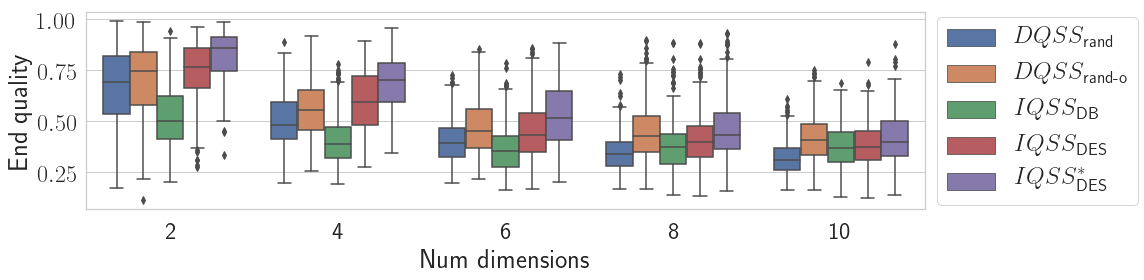

In [11]:
tmp = df_p1_success.query('qs_opt_method in ["None", "BlackBoxOptimization"]').reset_index(drop=True)
tmp.qs = tmp.qs.apply(lambda x: pretty_names['qs'][x])
tmp = tmp.rename(columns={'num_dimensions': 'numdim', 'm_end_quality': 'meq'})

f = pretty_plot(title=f'Average end quality', 
                x="numdim",
                y="meq",
                hue="qs",
                data=tmp,
                pretty_order=sorted(tmp.numdim.unique()),
                pretty_hue_order=list(pretty_names['qs'].values()),
                kind="box",
                plot_size=(16, 4))
f.axes[0].set_xlabel('Num dimensions')
f.axes[0].set_ylabel('End quality')
f.tight_layout()
f.savefig(f'{plot_output_path}/eval_synthetic.pdf')

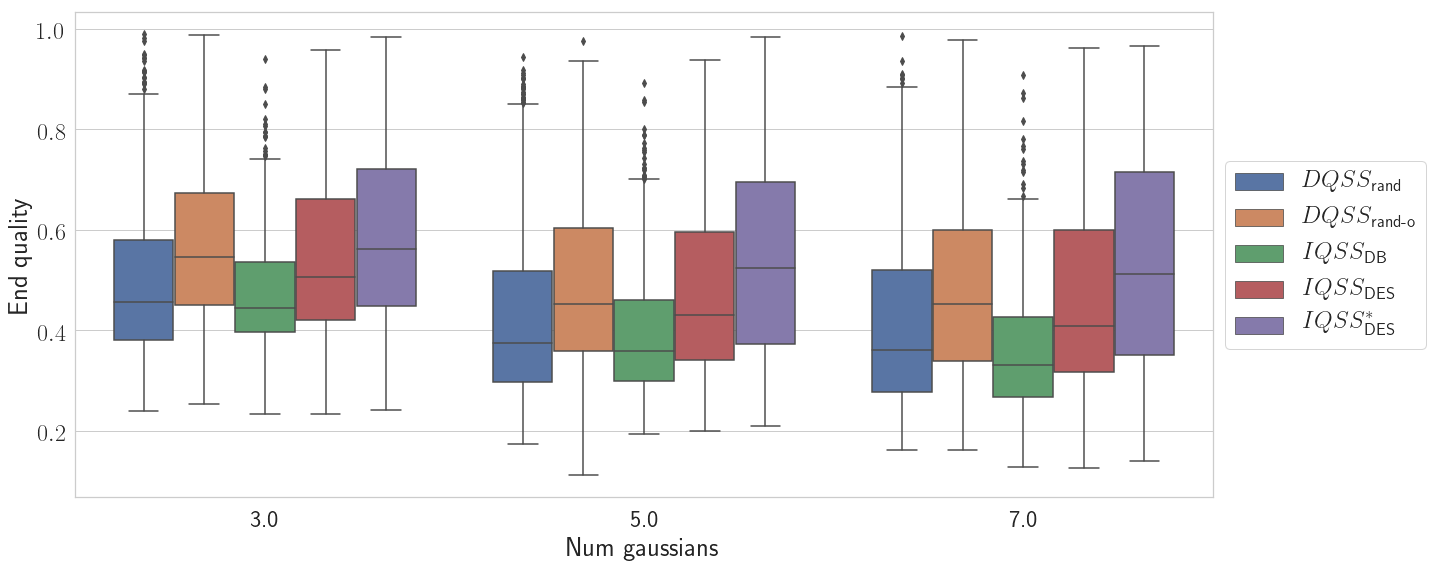

In [12]:
tmp = df_p1_success.query('qs_opt_method in ["None", "BlackBoxOptimization"]').reset_index(drop=True)
tmp.qs = tmp.qs.apply(lambda x: pretty_names['qs'][x])
tmp = tmp.rename(columns={'num_gaussians': 'numg', 'm_end_quality': 'meq'})

f = pretty_plot(title=f'Average end quality', 
                x="numg",
                y="meq",
                hue="qs",
                data=tmp,
                pretty_order=sorted(df_p1_success.num_gaussians.unique()),
                pretty_hue_order=list(pretty_names['qs'].values()),
                kind="box",
                plot_size=(20, 8))
f.axes[0].set_xlabel('Num gaussians')
f.axes[0].set_ylabel('End quality')
f.tight_layout()

### Comparison optimization methods

In [13]:
df_p1_success.groupby('qs_opt_method')[['time_qs_mean', 'time_qs_max', 'total_run_time']].agg(['mean', 'median', 'sum'])

time_qs_mean                         time_qs_max  \
                                  mean    median           sum        mean   
qs_opt_method                                                                
BlackBoxOptimization          4.894639  4.854043  20630.901913    8.801717   
None                          0.001769  0.000891      5.305748    0.126246   
ParticleSwarmOptimization     2.570666  1.610387  10565.436380    7.954771   

                                                  total_run_time              \
                             median           sum           mean      median   
qs_opt_method                                                                  
BlackBoxOptimization       9.036908  37099.239234     511.484145  506.930605   
None                       0.072121    378.612963      22.689139   14.378976   
ParticleSwarmOptimization  4.358761  32694.109802     279.491788  184.053951   

                                         
                                    sum  
qs_opt_method                            
BlackBoxOptimization       2.155906e+06  
None                       6.804473e+04  
ParticleSwarmOptimization  1.148711e+06

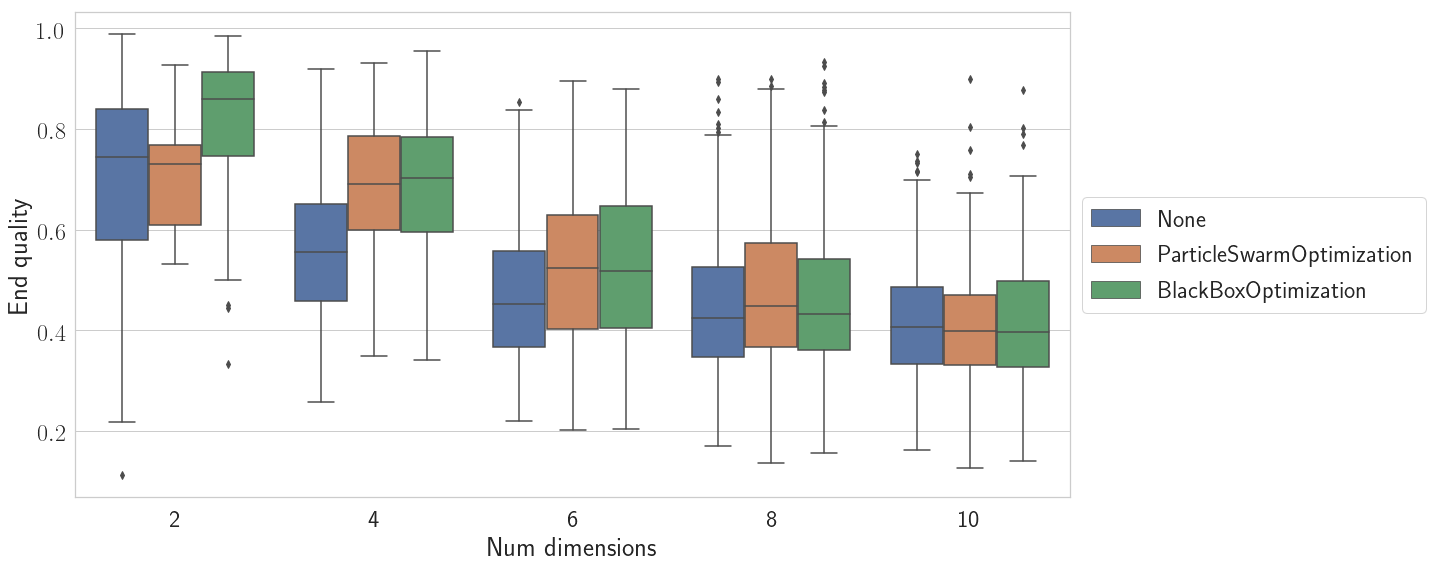

In [14]:
tmp = df_p1_success.query('qs in ["RandomOutlierQss", "ExplorativeMarginQss"]').reset_index(drop=True)
tmp.qs = tmp.qs.apply(lambda x: pretty_names['qs'][x])
tmp = tmp.rename(columns={'num_dimensions': 'numdim', 'm_end_quality': 'meq', 'qs_opt_method': 'qsoptm'})

f = pretty_plot(title=f'Average end quality', 
                x="numdim",
                y="meq",
                hue="qsoptm",
                data=tmp,
                pretty_order=sorted(df_p1_success.num_dimensions.unique()),
                pretty_hue_order=order['qs_opt_method'],
                kind="box",
                plot_size=(20, 8))
f.axes[0].set_xlabel('Num dimensions')
f.axes[0].set_ylabel('End quality')
f.tight_layout()

In [15]:
metric = "m_end_quality"
res = df_p1_success.query('qs in ["RandomOutlierQss", "ExplorativeMarginQss"]')
res = res.groupby(["num_dimensions", "qs_opt_method"]).mean()[[metric]].reset_index().pivot(index='qs_opt_method', columns='num_dimensions')[[metric]]
res = res.T.reset_index(level=0, drop=True).T
res = res.reset_index().round(decimals=2)
res.columns = [''] + [f'd = {x}' for x in res.columns[1:].values]
print(res.to_latex(escape=False, na_rep='-', index=False)) if print_latex else res.set_index(res.columns[0]).style.apply(highlight_max, axis=0)

,d = 2,d = 4,d = 6,d = 8,d = 10
,,,,,
BlackBoxOptimization,0.82,0.69,0.53,0.46,0.42
None,0.71,0.56,0.47,0.44,0.42
ParticleSwarmOptimization,0.71,0.69,0.52,0.47,0.41


# Real world data

In [16]:
target_scenario = 'eval_part_2_qss'

In [17]:
df_p2, df_p2_success = df_full.query('scenario == @target_scenario'), df_full_success.query('scenario == @target_scenario')

Data set size

In [18]:
df_p2.groupby(["data_set"])[['num_points']].max()

,num_points
data_set,
Annthyroid,7129
Arrhythmia,450
Cardiotocography,2114
Glass,214
HeartDisease,270
Hepatitis,80
InternetAds,1966
Ionosphere,351
PageBlocks,5393


Results for DXNES

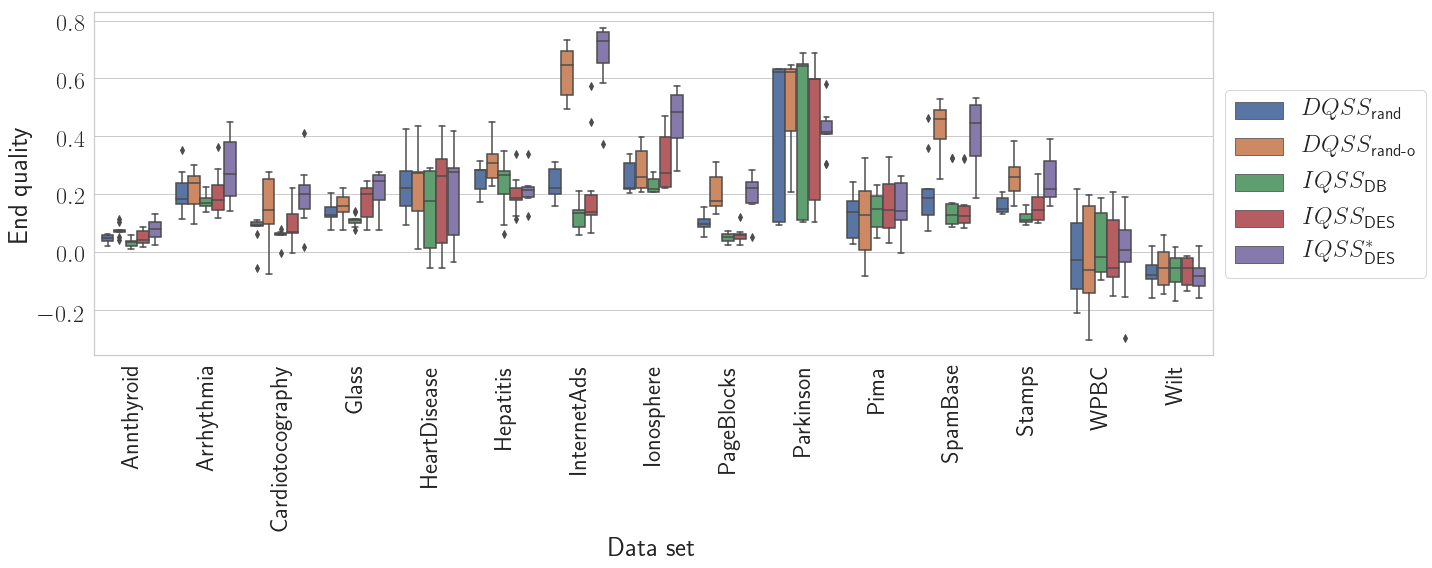

In [19]:
tmp = df_p2_success.query('qs_opt_method in ["None", "BlackBoxOptimization"]').reset_index(drop=True)
tmp.qs = tmp.qs.apply(lambda x: pretty_names['qs'][x])
tmp = tmp.rename(columns={'data_set': 'ds', 'm_end_quality': 'meq'})

f = pretty_plot(title=f'End quality', 
                x="ds",
                y="meq",
                hue="qs",
                data=tmp,
                pretty_order=sorted(df_p2_success.data_set.unique()),
                pretty_hue_order=list(pretty_names['qs'].values()),
                kind="box",
                plot_size=(20, 8))
f.axes[0].set_xlabel('Data set')
f.axes[0].set_ylabel('End quality')
plt.xticks(rotation=90)
f.tight_layout()

Start quality

In [20]:
df_p2_success.query('qs_opt_method in ["None", "BlackBoxOptimization"]').groupby('data_set').median()[['m_start_quality']]

,m_start_quality
data_set,
Annthyroid,0.032543
Arrhythmia,0.167706
Cardiotocography,0.063801
Glass,0.108120
HeartDisease,0.177087
Hepatitis,0.280811
InternetAds,0.129307
Ionosphere,0.215995
PageBlocks,0.051125


End quality

In [21]:
df_tmp = df_p2_success.query('qs_opt_method in ["None", "BlackBoxOptimization"]')
# For other metrics replace this value, e.g., with "m_quality_range"
metric = "m_end_quality"
res = df_tmp.query('qs_opt_method in ["None", "BlackBoxOptimization"]').groupby(["data_set", "qs"]).median()[[metric]].reset_index().pivot(index='data_set', columns = 'qs')[[metric]]
res = res.T.reset_index(level=0, drop=True).T.round(decimals=2)
res = res[list(pretty_names['qs'].keys())]
if print_latex:
    res.columns = [pretty_names['qs'][x] for x in res.columns]
res = res.reset_index()
res.columns = ['Data set'] + res.columns[1:].values.tolist()
print(res.to_latex(escape=False, na_rep='-', index=False)) if print_latex else res.set_index('Data set').style.apply(highlight_max, axis=1)

,RandomQss,RandomOutlierQss,DecisionBoundaryQss,ExplorativeMarginQss_NP,ExplorativeMarginQss
Data set,,,,,
Annthyroid,0.05,0.07,0.03,0.04,0.08
Arrhythmia,0.18,0.24,0.17,0.18,0.27
Cardiotocography,0.09,0.14,0.06,0.07,0.2
Glass,0.13,0.16,0.11,0.2,0.24
HeartDisease,0.22,0.27,0.18,0.26,0.28
Hepatitis,0.28,0.31,0.27,0.19,0.21
InternetAds,0.22,0.65,0.13,0.14,0.73
Ionosphere,0.22,0.26,0.22,0.27,0.49
PageBlocks,0.1,0.17,0.05,0.06,0.22


### Comparison optimization methods

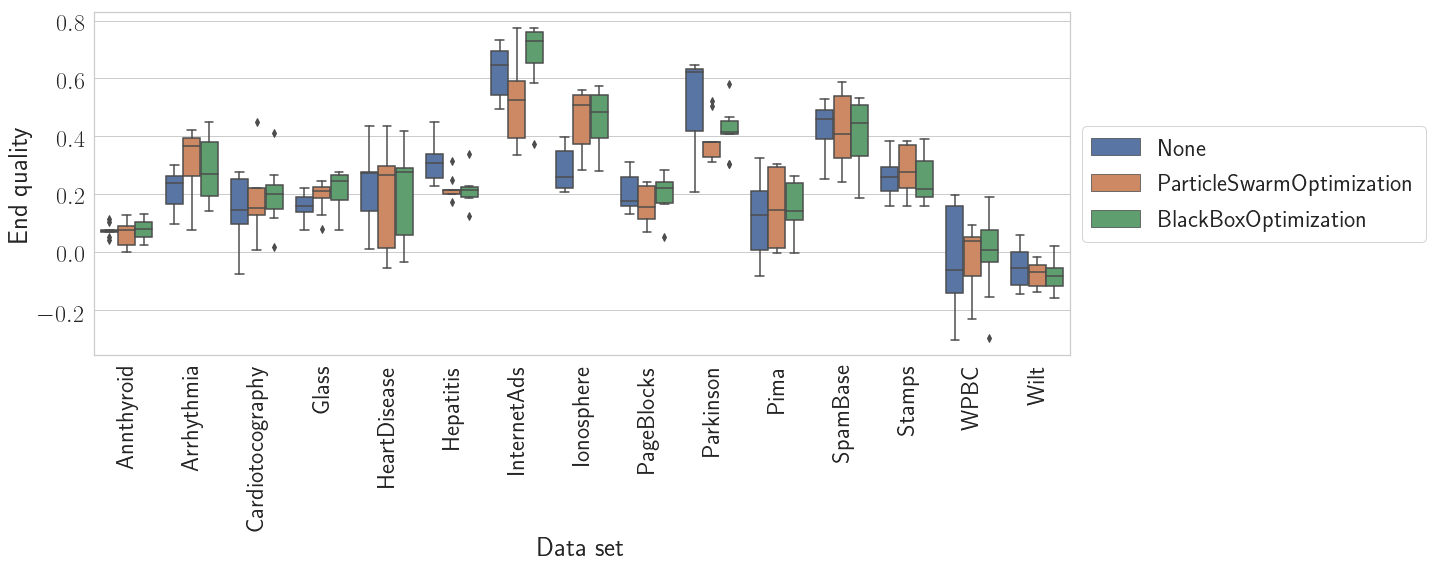

In [22]:
tmp = df_p2_success.query('qs in ["RandomOutlierQss", "ExplorativeMarginQss"]').reset_index(drop=True)
tmp.qs = tmp.qs.apply(lambda x: pretty_names['qs'][x])
tmp = tmp.rename(columns={'data_set': 'ds', 'm_end_quality': 'meq', 'qs_opt_method': 'qsoptm'})

f = pretty_plot(title=f'End Quality', 
                x="ds",
                y="meq",
                hue="qsoptm",
                data=tmp,
                pretty_order=sorted(df_p2_success.data_set.unique()),
                pretty_hue_order=order['qs_opt_method'],
                kind="box",
                plot_size=(20, 8))
f.axes[0].set_xlabel('Data set')
f.axes[0].set_ylabel('End quality')
plt.xticks(rotation=90)
f.tight_layout()